/var/folders/wx/q14bm8054cb77_k6246tdlg00000gn/T/ipykernel_1724/292997533.py:27: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
2025-04-22 21:32:14.244389: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-22 21:32:14.244414: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-22 21:32:14.244421: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-22 21:32:14.244436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-22 21:32:14.244446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device

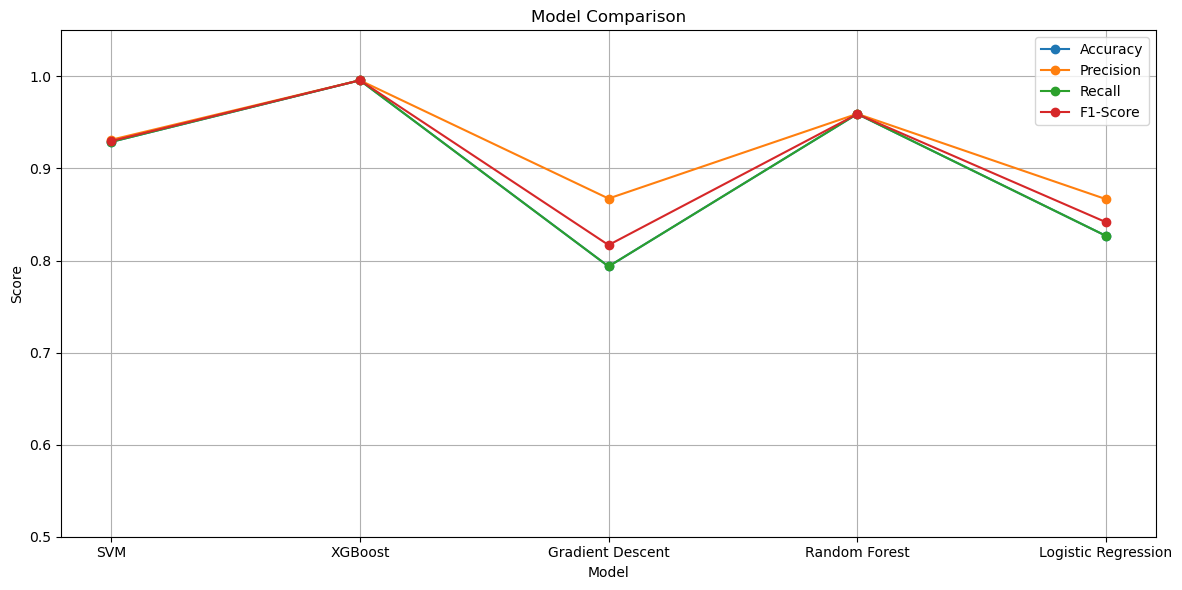

In [1]:
# Cell 1 - Imports
import os
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Cell 2 - Define paths
MODEL_PATHS = {
    'SVM': '../results/reports/svm_model.pkl',
    'XGBoost': '../results/reports/model_xgboost.pkl',
    'Gradient Descent': '../results/reports/gd_model.pkl',
    'Random Forest': '../results/reports/model_RandomForest.pkl',
    'Logistic Regression': '../results/reports/logistic_model.pkl',
}

DATA_PATH = '../data/processed/marine_water_quality_cleaned.csv'

# Cell 3 - Load and preprocess data
df = pd.read_csv(DATA_PATH)
df.replace(to_replace=r"<([0-9.]+)", value=lambda m: str(m.group(1)), regex=True, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')

X = df.drop(columns=['label'])
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X = X.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Cell 4 - Evaluate models with GPU
results = []

with tf.device('/device:GPU:0'):
    for name, path in MODEL_PATHS.items():
        model, label_encoder = joblib.load(path)

        try:
            n_features_required = model.n_features_in_
            if X_test.shape[1] != n_features_required:
                print(f"[WARNING] {name} model expects {n_features_required} features, but got {X_test.shape[1]}. Skipping.")
                continue

            y_pred = model.predict(X_test)

            results.append({
                'Model': name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
                'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
            })

        except Exception as e:
            print(f"[ERROR] Could not evaluate {name}: {str(e)}")

results_df = pd.DataFrame(results)

# Cell 5 - Plot comparison
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

with tf.device('/device:GPU:0'):
    for metric in metrics:
        plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0.5, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Save summary
results_df.to_csv('../results/model_comparison_summary.csv', index=False)
